In [1]:
from awpy import Demo

import torch
from torch_geometric_temporal.signal import DynamicHeteroGraphTemporalSignal

import pandas as pd
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import time
import json
import sys
import os

pd.set_option('display.max_columns', 100)
pd.set_option('future.no_silent_downcasting', True)

pl.Config.set_tbl_rows(10)

sys.path.append(os.path.abspath('../../package'))

from CS2.graph import TabularGraphSnapshot, HeteroGraphSnapshot, TemporalHeteroGraphSnapshot
from CS2.token import Tokenizer
from CS2.preprocess import Dictionary, NormalizePosition, NormalizeTabularGraphSnapshot, ImputeTabularGraphSnapshot
from CS2.visualize import HeteroGraphVisualizer

### 1. Tabular Dataset Creation

#### 2023 Matches

Parse date: 2024. 09. 28.

In [3]:
# --------------------------------------------------
# PREPARATION
# --------------------------------------------------

MATCH_FOLDER_PATH = '../../data/matches-raw/cs2/2023/'
SAVE_PATH = '../../data/matches-processed/cs2/tabular/2023/'

# Get inferno matches
match_list = os.listdir(MATCH_FOLDER_PATH)
inferno_match_list = [file for file in match_list if 'inferno' in file and 
    '-p1' not in file and 
    '-p2' not in file and 
    '-p3' not in file and 
    '-p4' not in file and 
    '-p5' not in file
]

# Save complete match list and process time
parsed_matches_list = []
error_matches_list = []
process_time_list = []

# Match index
match_index = 0



# Read the files if they exist
if os.path.exists('completed_matches.txt'):
    with open('completed_matches.txt', 'r') as file:
        parsed_matches_list = [line.strip() for line in file]

if os.path.exists('error_matches.txt'):
    with open('error_matches.txt', 'r') as file:
        error_matches_list = [line.strip() for line in file]

if os.path.exists('process_times.txt'):
    with open('process_times.txt', 'r') as file:
        process_time_list = [line.strip() for line in file]

if os.path.exists('match_index.txt'):
    with open('match_index.txt', 'r') as file:
        match_index = int(file.read())


# Map nodes dataset
nodes = pd.read_csv('../../data/map_graph_model/de_inferno/nodes.csv')



# --------------------------------------------------
# PARSE MATCHES
# --------------------------------------------------

# Parse Inferno matches
for match in inferno_match_list:

    # If the match has already been parsed or is corrupted, skip it
    if match in parsed_matches_list or match in error_matches_list:
        continue

    # Start timer
    start_time = time.time()

    # Match path
    match_path = MATCH_FOLDER_PATH + match

    # Create tabular snapshot object
    tg = TabularGraphSnapshot()

    print('-----------------------------------------------------------------------------------------------------------------------------')
    print('                                                        PARSING MATCH                                                        \n')
    print('Match: ' + match)

    try:
        # Create tabular snapshot database
        df, df_dict, active_infernos, active_smokes, active_he_smokes = tg.process_match(
            match_path=match_path,
            player_stats_data_path='../../data/player-stats/scraped-in-2024/2022/norm_player_stats_2022.csv',
            missing_player_stats_data_path='../../data/player-stats/missing_players_df_2022.csv',
            weapon_data_path='../../data/weapon_info/ammo_info.csv',

            ticks_per_second=4,
            numerical_match_id=100000 + match_index,
            num_permutations_per_round=1,
            build_dictionary=True,

            package='pandas'
        )

        # Impute missing values
        its = ImputeTabularGraphSnapshot()
        df = its.impute(df)

        # Tokenize match
        tokenizer = Tokenizer()
        df = tokenizer.tokenize_match(df, 'de_inferno', nodes)

        # Save dataframes
        df.to_csv(SAVE_PATH + str(100000 + match_index) + match + '_df.csv', index=False)
        df_dict.to_csv(SAVE_PATH + str(100000 + match_index) + match + '_df_dict.csv', index=False)
        active_infernos.to_csv(SAVE_PATH + str(100000 + match_index) + match + '_active_infernos.csv', index=False)
        active_smokes.to_csv(SAVE_PATH + str(100000 + match_index) + match + '_active_smokes.csv', index=False)
        active_he_smokes.to_csv(SAVE_PATH + str(100000 + match_index) + match + '_active_he_smokes.csv', index=False)

    except Exception as e:
        # Print info and save error matches
        print('Error occured while parsing the match. Skipping match.')

        error_matches_list.append(match)
        with open('error_matches.txt', 'w') as file:
            for item in error_matches_list:
                file.write(f"{item}\n")
                
        continue


    # Post-process
    match_index += 1
    parsed_matches_list.append(match)



    # --------------------------------------------------
    # LOG AND SAVE TIME
    # --------------------------------------------------
    
    # Time
    end_time = time.time()
    process_time = end_time - start_time
    process_time_list.append(process_time)

    # Write results to file
    with open('completed_matches.txt', 'w') as file:
        for item in parsed_matches_list:
            file.write(f"{item}\n")
    
    with open('process_times.txt', 'w') as file:
        for item in process_time_list:
            file.write(f"{item}\n")
    
    with open('match_index.txt', 'w') as file:
        file.write(str(match_index))

    print('Parse completed. Duration: ' + str(process_time) + ' seconds.')

-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-fall-final-2023-cloud9-vs-heroic-bo3-FZhx5bice3pWss26wFHIIYcloud9-vs-heroic-m2-inferno.dem
Info: The output variable values are [2, 3].
Parse completed. Duration: 97.30189275741577 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-fall-final-2023-cloud9-vs-natus-vincere-bo3-vxKYiMWUPLiYn9oyBq6Njdcloud9-vs-natus-vincere-m3-inferno.dem
Info: The output variable values are [3, 2].
Parse completed. Duration: 116.72303366661072 seconds.
-------------------------------------------------------

2024-09-28 14:37:18.453 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are [2, 3].
Parse completed. Duration: 120.30640053749084 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-world-final-2023-faze-vs-vitality-bo3-ClpxEnxu3aH1RMZr76QdPjfaze-vs-vitality-m1-inferno.dem
Info: The output variable values are [3, 2].
Parse completed. Duration: 113.43186807632446 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-world-final-2023-natus-vincere-vs-g2-bo3-kBFM-G_7fInl0UI1EoqFsNnatus-vincere-vs-g2-m2-inferno.dem
Info: The output variable values are [2, 3].
Parse completed

2024-09-28 14:46:21.288 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are [3, 2].
Parse completed. Duration: 118.94560861587524 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _cs-asia-championships-2023-mouz-vs-wings-up-inferno-rBbDAQbfvHTcx042LMx-mOmouz-vs-wings-up-inferno.dem
Info: The output variable values are [2, 3].
Parse completed. Duration: 89.94858193397522 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _iem-sydney-2023-complexity-vs-cloud9-bo3-tS4DKYhEODwQi32UeWBvWlcomplexity-vs-cloud9-m3-inferno.dem
Info: The output variable values are [3, 2].
Error occured while parsing the 

2024-09-28 14:52:51.095 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are [2, 3].
Error occured while parsing the match. Skipping match.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _iem-sydney-2023-natus-vincere-vs-mouz-bo3-kmz24m_e2rc4e07yRHJsFcnatus-vincere-vs-mouz-m2-inferno.dem


2024-09-28 14:54:11.142 | WARNING  | awpy.parsers.events:parse_bomb:309 - bomb_exploded not found in events.


Info: The output variable values are [3, 2].
Error occured while parsing the match. Skipping match.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _iem-sydney-2023-vitality-vs-faze-bo3-KYy8n7ELEDs3OUXK1CHiYpvitality-vs-faze-m2-inferno.dem
Info: The output variable values are [2, 3].
Error occured while parsing the match. Skipping match.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _roobet-cup-2023-fnatic-vs-ninjas-in-pyjamas-bo3-vvaeYNK3nyhj-S-LM5M0XFfnatic-vs-ninjas-in-pyjamas-m1-inferno.dem
Info: The output variable values are [3, 2].
Parse completed. Duration: 14

2024-09-28 15:07:39.921 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are [2, 3].
Parse completed. Duration: 87.55010962486267 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _thunderpick-world-championship-2023-fnatic-vs-ninjas-in-pyjamas-bo3-6iVaParaf7r9nrM0X_nIUKfnatic-vs-ninjas-in-pyjamas-m2-inferno.dem
Info: The output variable values are [3, 2].
Parse completed. Duration: 269.02245259284973 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _thunderpick-world-championship-2023-fnatic-vs-virtuspro-bo3-TIXlP91jgLe7XdTNek2melfnatic-vs-virtus-pro-m2-inferno.dem
Error: Incorrect output vari

#### 2024 Matches

Parse date: 2024. 09. 28.

In [4]:
# --------------------------------------------------
# PREPARATION
# --------------------------------------------------

MATCH_FOLDER_PATH = '../../data/matches-raw/cs2/2024/'
SAVE_PATH = '../../data/matches-processed/cs2/tabular/2024/'

# Get inferno matches
match_list = os.listdir(MATCH_FOLDER_PATH)
inferno_match_list = [file for file in match_list if 'inferno' in file and 
    '-p1' not in file and 
    '-p2' not in file and 
    '-p3' not in file and 
    '-p4' not in file and 
    '-p5' not in file
]

# Save complete match list and process time
parsed_matches_list = []
error_matches_list = []
process_time_list = []

# Match index
match_index = 0



# Read the files if they exist
if os.path.exists('completed_matches.txt'):
    with open('completed_matches.txt', 'r') as file:
        parsed_matches_list = [line.strip() for line in file]

if os.path.exists('error_matches.txt'):
    with open('error_matches.txt', 'r') as file:
        error_matches_list = [line.strip() for line in file]

if os.path.exists('process_times.txt'):
    with open('process_times.txt', 'r') as file:
        process_time_list = [line.strip() for line in file]

if os.path.exists('match_index.txt'):
    with open('match_index.txt', 'r') as file:
        match_index = int(file.read())


# Map nodes dataset
nodes = pd.read_csv('../../data/map_graph_model/de_inferno/nodes.csv')



# --------------------------------------------------
# PARSE MATCHES
# --------------------------------------------------

# Parse Inferno matches
for match in inferno_match_list:

    # If the match has already been parsed or is corrupted, skip it
    if match in parsed_matches_list or match in error_matches_list:
        continue

    # Start timer
    start_time = time.time()

    # Match path
    match_path = MATCH_FOLDER_PATH + match

    # Create tabular snapshot object
    tg = TabularGraphSnapshot()

    print('-----------------------------------------------------------------------------------------------------------------------------')
    print('                                                        PARSING MATCH                                                        \n')
    print('Match: ' + match)

    try:
        # Create tabular snapshot database
        df, df_dict, active_infernos, active_smokes, active_he_smokes = tg.process_match(
            match_path=match_path,
            player_stats_data_path='../../data/player-stats/scraped-in-2024/2023/norm_player_stats_2023.csv',
            missing_player_stats_data_path='../../data/player-stats/missing_players_df_2023.csv',
            weapon_data_path='../../data/weapon_info/ammo_info.csv',

            ticks_per_second=4,
            numerical_match_id=100000 + match_index,
            num_permutations_per_round=1,
            build_dictionary=True,

            package='pandas'
        )

    except Exception as e:
        # Print info and save error matches
        print('Error occured while parsing the match. Skipping match.')

        error_matches_list.append(match)
        with open('error_matches.txt', 'w') as file:
            for item in error_matches_list:
                file.write(f"{item}\n")
                
        continue



    # Impute missing values
    its = ImputeTabularGraphSnapshot()
    df = its.impute(df)

    # Tokenize match
    tokenizer = Tokenizer()
    df = tokenizer.tokenize_match(df, 'de_inferno', nodes)

    # Save dataframes
    df.to_csv(SAVE_PATH + match + '_df.csv', index=False)
    df_dict.to_csv(SAVE_PATH + match + '_df_dict.csv', index=False)
    active_infernos.to_csv(SAVE_PATH + match + '_active_infernos.csv', index=False)
    active_smokes.to_csv(SAVE_PATH + match + '_active_smokes.csv', index=False)
    active_he_smokes.to_csv(SAVE_PATH + match + '_active_he_smokes.csv', index=False)

    # Post-process
    match_index += 1
    parsed_matches_list.append(match)



    # --------------------------------------------------
    # LOG AND SAVE TIME
    # --------------------------------------------------
    
    # Time
    end_time = time.time()
    process_time = end_time - start_time
    process_time_list.append(process_time)

    # Write results to file
    with open('completed_matches.txt', 'w') as file:
        for item in parsed_matches_list:
            file.write(f"{item}\n")
    
    with open('process_times.txt', 'w') as file:
        for item in process_time_list:
            file.write(f"{item}\n")
    
    with open('match_index.txt', 'w') as file:
        file.write(str(match_index))

    print('Parse completed. Duration: ' + str(process_time) + ' seconds.')

-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _betboom-dacha-belgrade-season-2-eternal-fire-vs-pain-bo3-EsO1ghXhDey0Ii85scyL6seternal-fire-vs-pain-m1-inferno.dem
Info: The output variable values are ['T', 'CT'].
Parse completed. Duration: 165.88144898414612 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _betboom-dacha-belgrade-season-2-mouz-vs-eternal-fire-bo3-5Hd0ELRRmki7NgbHcMS0LRmouz-vs-eternal-fire-m1-inferno.dem


2024-09-28 15:45:05.533 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are ['CT', 'T'].
Parse completed. Duration: 127.88487839698792 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _betboom-dacha-belgrade-season-2-virtuspro-vs-furia-bo3-L9mXEKkAd1k6NSuXJ6zD7Mvirtus-pro-vs-furia-m1-inferno.dem


2024-09-28 15:47:11.915 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are ['T', 'CT'].
Parse completed. Duration: 113.87923383712769 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-fall-groups-2024-astralis-vs-ninjas-in-pyjamas-bo3-K9s9BWKc9ebp95rNa21UfDastralis-vs-ninjas-in-pyjamas-m2-inferno.dem


2024-09-28 15:49:21.456 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are ['CT', 'T'].
Parse completed. Duration: 125.9741849899292 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-fall-groups-2024-faze-vs-cloud9-bo3-ihmdAcNeCnnXz-kUWDRQWJfaze-vs-cloud9-m2-inferno.dem
Info: The output variable values are ['CT', 'T'].
Parse completed. Duration: 139.82412314414978 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-fall-groups-2024-faze-vs-ninjas-in-pyjamas-bo3-VdTvo-LqKO90fOrCjapEhefaze-vs-ninjas-in-pyjamas-m2-inferno.dem
Info: The output variable values are ['CT',

2024-09-28 16:00:11.170 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are ['T', 'CT'].
Parse completed. Duration: 149.2838671207428 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-fall-groups-2024-liquid-vs-natus-vincere-bo3-9lpEgKl63kwjYP50O3GePuliquid-vs-natus-vincere-m3-inferno.dem
Info: The output variable values are ['T', 'CT'].
Parse completed. Duration: 166.76204180717468 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _blast-premier-fall-groups-2024-natus-vincere-vs-liquid-bo3-HiBy2g4xxH8GhJ5oS20Cg1natus-vincere-vs-liquid-m3-inferno.dem
Info: The output variable val

2024-09-28 17:15:10.591 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are ['CT', 'T'].
Parse completed. Duration: 131.66930055618286 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _esl-pro-league-season-19-flyquest-vs-boss-bo3-kepHm-hcQrxwScc1lUPTr2flyquest-vs-boss-m1-inferno.dem
Info: The output variable values are ['CT', 'T'].
Parse completed. Duration: 130.34393787384033 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _esl-pro-league-season-19-fnatic-vs-eternal-fire-bo3-5JQYu14q1Pr45JXnu54B5tfnatic-vs-eternal-fire-m2-inferno.dem
Info: The output variable values are ['T', 'CT'].
Parse 

2024-09-28 17:55:02.651 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are ['T', 'CT'].
Parse completed. Duration: 117.14281702041626 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _esports-world-cup-2024-vitality-vs-virtuspro-bo3-OIBFPb4RnnZFIizTerdsOLvitality-vs-virtus-pro-m2-inferno.dem


2024-09-28 17:57:12.097 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are ['CT', 'T'].
Parse completed. Duration: 171.29082083702087 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _iem-chengdu-2024-astralis-vs-faze-bo3-6olLictlFt5IKY_IO-7a67astralis-vs-faze-m3-inferno.dem


2024-09-28 17:59:54.138 | WARNING  | awpy.parsers.events:parse_bomb:279 - bomb_defused not found in events.


Info: The output variable values are ['CT', 'T'].
Parse completed. Duration: 167.11326670646667 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _iem-chengdu-2024-faze-vs-nemiga-inferno-nU4rMy8WGKJ4acojeE4uk4faze-vs-nemiga-inferno.dem
Info: The output variable values are ['T', 'CT'].
Parse completed. Duration: 180.2752342224121 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _iem-chengdu-2024-flyquest-vs-nemiga-bo3-USesJ2H32Xwl0eK0l6gYPDflyquest-vs-nemiga-m2-inferno.dem
Info: The output variable values are ['T', 'CT'].
Parse completed. Duration: 222.718

### 2. Heterogeneous Graph Dataset Creation

#### 2.1 Create Dictionary

In [4]:
# File paths
MATCH_FOLDER_PATH_2023 = '../../data/matches-processed/cs2/tabular/2023/'
MATCH_FOLDER_PATH_2024 = '../../data/matches-processed/cs2/tabular/2024/'

# Get files in the folders
file_list_2023 = os.listdir(MATCH_FOLDER_PATH_2023)
file_list_2024 = os.listdir(MATCH_FOLDER_PATH_2024)



# --------------------------------------------------
# Build Dictionary
# --------------------------------------------------

# Get dictionary files
df_dict_list_2023 = [file for file in file_list_2023 if file.endswith('_df_dict.csv')]
df_dict_list_2024 = [file for file in file_list_2024 if file.endswith('_df_dict.csv')]

# Build dictionaries
dict_2023 = Dictionary().build_dictionary(MATCH_FOLDER_PATH_2023, df_dict_list_2023)
dict_2024 = Dictionary().build_dictionary(MATCH_FOLDER_PATH_2024, df_dict_list_2024)

# Merge dictionaries
dictionary = Dictionary().merge_dictionaries([dict_2023, dict_2024])

# Save dictionary
dictionary.to_csv('dictionary_2023-2024.09_2024.09.28.csv', index=False)

#### 2.2 Create Heterogeneous Graph Snahpots

In [5]:
# Get CONFIG parameters
inferno_pos_norm_config = '../../config/map_normalization/inferno.json'
molotov_radius_config = '../../config/nade_radius/molotov_norm.json'
smoke_radius_config = '../../config/nade_radius/smoke_norm.json'

with open(inferno_pos_norm_config, 'r') as f:
    CONFIG_INF_POS_NORM = json.load(f)
with open(molotov_radius_config, 'r') as f:
    CONFIG_MOLOTOV_RADIUS = json.load(f)
with open(smoke_radius_config, 'r') as f:
    CONFIG_SMOKE_RADIUS = json.load(f)

##### 2023

In [6]:
# Graph save path
GRAPH_SAVE_PATH = '../../data/matches-processed/cs2/hetero-graph/'

# Get match list
df_match_list_2023 = [file for file in file_list_2023 if file.endswith('_df.csv')]

# Nodes and edges dataframes
nodes_to_use = pd.read_csv('../../data/map_graph_model/de_inferno/nodes_norm.csv')
edges = pd.read_csv('../../data/map_graph_model/de_inferno/edges.csv')

# Save complete match list and process time
parsed_matches_list = []
error_matches_list = []
process_time_list = []

# Read the files if they exist
if os.path.exists('completed_matches.txt'):
    with open('completed_matches.txt', 'r') as file:
        parsed_matches_list = [line.strip() for line in file]

if os.path.exists('error_matches.txt'):
    with open('error_matches.txt', 'r') as file:
        error_matches_list = [line.strip() for line in file]

if os.path.exists('process_times.txt'):
    with open('process_times.txt', 'r') as file:
        process_time_list = [line.strip() for line in file]


# Iterate over the matches
for match in df_match_list_2023:

    # Start timer
    start_time = time.time()

    print('-----------------------------------------------------------------------------------------------------------------------------')
    print('                                                        PARSING MATCH                                                        \n')
    print('Match: ' + match)

    try:
        # Read dataframes
        df = pd.read_csv(MATCH_FOLDER_PATH_2023 + match)
        active_infernos = pd.read_csv(MATCH_FOLDER_PATH_2023 + match.replace('_df.csv', '_active_infernos.csv'))
        active_smokes = pd.read_csv(MATCH_FOLDER_PATH_2023 + match.replace('_df.csv', '_active_smokes.csv'))
        try:
            active_he_smokes = pd.read_csv(MATCH_FOLDER_PATH_2023 + match.replace('_df.csv', '_active_he_smokes.csv'))
        except:
            active_he_smokes = pd.DataFrame(columns=['tick', 'round', 'X', 'Y', 'Z'])
            print('No HE thrown into smokes in the match. Creating empty dataframe.')

        # Normalize active nade dataframes
        np = NormalizePosition()
        active_infernos = np.normalize(active_infernos, CONFIG_INF_POS_NORM)
        active_smokes = np.normalize(active_smokes, CONFIG_INF_POS_NORM)
        active_he_smokes = np.normalize(active_he_smokes, CONFIG_INF_POS_NORM)

        # Normalize tabular snapshot
        nts = NormalizeTabularGraphSnapshot()
        df = nts.noramlize(df, dictionary, CONFIG_INF_POS_NORM)

        # Graph snapshots
        hg = HeteroGraphSnapshot()
        graphs = hg.process_snapshots(df, nodes_to_use, edges, active_infernos, active_smokes, active_he_smokes, CONFIG_MOLOTOV_RADIUS, CONFIG_SMOKE_RADIUS)

        # Save graph snapshots
        torch.save(graphs, GRAPH_SAVE_PATH + str(df['NUMERICAL_MATCH_ID'].iloc[0]) + '.pt')

        # Save post-processed match
        parsed_matches_list.append(match)
    
        # Time
        end_time = time.time()
        process_time = end_time - start_time
        process_time_list.append(process_time)

        # Write results to file
        with open('completed_matches.txt', 'w') as file:
            for item in parsed_matches_list:
                file.write(f"{item}\n")
        
        with open('process_times.txt', 'w') as file:
            for item in process_time_list:
                file.write(f"{item}\n")

        print('Parse completed. Duration: ' + str(process_time) + ' seconds.')


    except Exception as e:
        
        # Print info and save error matches
        print('Error occured while parsing, skipping match. Error message:')
        print(e)

        error_matches_list.append(match)
        with open('error_matches.txt', 'w') as file:
            for item in error_matches_list:
                file.write(f"{item}\n")
                
        continue
    

-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: 100000_blast-premier-fall-final-2023-cloud9-vs-heroic-bo3-FZhx5bice3pWss26wFHIIYcloud9-vs-heroic-m2-inferno.dem_df.csv
Parse completed. Duration: 76.22841620445251 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: 100001_blast-premier-fall-final-2023-cloud9-vs-natus-vincere-bo3-vxKYiMWUPLiYn9oyBq6Njdcloud9-vs-natus-vincere-m3-inferno.dem_df.csv
Parse completed. Duration: 84.04479146003723 seconds.
------------------------------------------------------------------------------------------------------------------------

C:\Users\szmid\AppData\Local\Temp\ipykernel_29060\2388612964.py:42: DtypeWarning: Columns (1677,1678) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(MATCH_FOLDER_PATH_2023 + match)


Parse completed. Duration: 73.18819904327393 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: 100011_cs-asia-championships-2023-mouz-vs-wings-up-inferno-rBbDAQbfvHTcx042LMx-mOmouz-vs-wings-up-inferno.dem_df.csv


C:\Users\szmid\AppData\Local\Temp\ipykernel_29060\2388612964.py:42: DtypeWarning: Columns (1677,1678) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(MATCH_FOLDER_PATH_2023 + match)


Parse completed. Duration: 51.73904371261597 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: 100012_iem-sydney-2023-gamerlegion-vs-faze-bo3-8GCYTI5P5NZCLcg9Xq9-bagamerlegion-vs-faze-m2-inferno.dem_df.csv
No HE thrown into smokes in the match. Creating empty dataframe.
Parse completed. Duration: 75.37056088447571 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: 100012_iem-sydney-2023-mouz-vs-vertex-inferno-wyV4hHh3mDqNZhY8zBC_ttmouz-vs-vertex-inferno.dem_df.csv
No HE thrown into smokes in the match. Creating empty dataframe.
Parse completed. Duration: 46

##### 2024

In [7]:
# Graph save path
GRAPH_SAVE_PATH = '../../data/matches-processed/cs2/hetero-graph/'

# Get match list
df_match_list_2024 = [file for file in file_list_2024 if file.endswith('_df.csv')]

# Nodes and edges dataframes
nodes_to_use = pd.read_csv('../../data/map_graph_model/de_inferno/nodes_norm.csv')
edges = pd.read_csv('../../data/map_graph_model/de_inferno/edges.csv')

# Save complete match list and process time
parsed_matches_list = []
error_matches_list = []
process_time_list = []

# Read the files if they exist
if os.path.exists('completed_matches.txt'):
    with open('completed_matches.txt', 'r') as file:
        parsed_matches_list = [line.strip() for line in file]

if os.path.exists('error_matches.txt'):
    with open('error_matches.txt', 'r') as file:
        error_matches_list = [line.strip() for line in file]

if os.path.exists('process_times.txt'):
    with open('process_times.txt', 'r') as file:
        process_time_list = [line.strip() for line in file]


# Iterate over the matches
for match in df_match_list_2024:

    # Start timer
    start_time = time.time()

    print('-----------------------------------------------------------------------------------------------------------------------------')
    print('                                                        PARSING MATCH                                                        \n')
    print('Match: ' + match)

    try:
        # Read dataframes
        df = pd.read_csv(MATCH_FOLDER_PATH_2024 + match)
        active_infernos = pd.read_csv(MATCH_FOLDER_PATH_2024 + match.replace('_df.csv', '_active_infernos.csv'))
        active_smokes = pd.read_csv(MATCH_FOLDER_PATH_2024 + match.replace('_df.csv', '_active_smokes.csv'))
        try:
            active_he_smokes = pd.read_csv(MATCH_FOLDER_PATH_2024 + match.replace('_df.csv', '_active_he_smokes.csv'))
        except:
            active_he_smokes = pd.DataFrame(columns=['tick', 'round', 'X', 'Y', 'Z'])
            print('No HE thrown into smokes in the match. Creating empty dataframe.')

        # Normalize active nade dataframes
        np = NormalizePosition()
        active_infernos = np.normalize(active_infernos, CONFIG_INF_POS_NORM)
        active_smokes = np.normalize(active_smokes, CONFIG_INF_POS_NORM)
        active_he_smokes = np.normalize(active_he_smokes, CONFIG_INF_POS_NORM)

        # Normalize tabular snapshot
        nts = NormalizeTabularGraphSnapshot()
        df = nts.noramlize(df, dictionary, CONFIG_INF_POS_NORM)

        # Graph snapshots
        hg = HeteroGraphSnapshot()
        graphs = hg.process_snapshots(df, nodes_to_use, edges, active_infernos, active_smokes, active_he_smokes, CONFIG_MOLOTOV_RADIUS, CONFIG_SMOKE_RADIUS)

        # Save graph snapshots
        torch.save(graphs, GRAPH_SAVE_PATH + str(df['NUMERICAL_MATCH_ID'].iloc[0]) + '.pt')

        # Save post-processed match
        parsed_matches_list.append(match)
    
        # Time
        end_time = time.time()
        process_time = end_time - start_time
        process_time_list.append(process_time)

        # Write results to file
        with open('completed_matches.txt', 'w') as file:
            for item in parsed_matches_list:
                file.write(f"{item}\n")
        
        with open('process_times.txt', 'w') as file:
            for item in process_time_list:
                file.write(f"{item}\n")

        print('Parse completed. Duration: ' + str(process_time) + ' seconds.')


    except Exception as e:
        
        # Print info and save error matches
        print('Error occured while parsing, skipping match. Error message:')
        print(e)

        error_matches_list.append(match)
        with open('error_matches.txt', 'w') as file:
            for item in error_matches_list:
                file.write(f"{item}\n")
                
        continue
    

-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _betboom-dacha-belgrade-season-2-eternal-fire-vs-pain-bo3-EsO1ghXhDey0Ii85scyL6seternal-fire-vs-pain-m1-inferno.dem_df.csv
Parse completed. Duration: 98.97523212432861 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _betboom-dacha-belgrade-season-2-mouz-vs-eternal-fire-bo3-5Hd0ELRRmki7NgbHcMS0LRmouz-vs-eternal-fire-m1-inferno.dem_df.csv
Parse completed. Duration: 81.74044561386108 seconds.
-----------------------------------------------------------------------------------------------------------------------------


C:\Users\szmid\AppData\Local\Temp\ipykernel_29060\937563431.py:42: DtypeWarning: Columns (0,820) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(MATCH_FOLDER_PATH_2024 + match)


Parse completed. Duration: 179.91735410690308 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _pgl-cs2-major-copenhagen-2024-virtuspro-vs-g2-bo3-_HljkSgUssxnv7gY6zueWRvirtus-pro-vs-g2-m2-inferno.dem_df.csv
Parse completed. Duration: 115.55023097991943 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _pgl-cs2-major-copenhagen-2024-virtuspro-vs-imperial-inferno-khjhOWhI70GAS-g9WWfGzcvirtus-pro-vs-imperial-inferno.dem_df.csv
Parse completed. Duration: 124.3142352104187 seconds.
-------------------------------------------------------------------------------

C:\Users\szmid\AppData\Local\Temp\ipykernel_29060\937563431.py:42: DtypeWarning: Columns (0,820) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(MATCH_FOLDER_PATH_2024 + match)


Parse completed. Duration: 90.1720118522644 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _yalla-compass-2024-complexity-vs-big-inferno-0NOZtg3Sw8z-wQPgDTN6_8complexity-vs-big-inferno.dem_df.csv
Parse completed. Duration: 74.74949765205383 seconds.
-----------------------------------------------------------------------------------------------------------------------------
                                                        PARSING MATCH                                                        

Match: _yalla-compass-2024-complexity-vs-furia-inferno-nNF-QzYEPXKM32ZGDbj_Xqcomplexity-vs-furia-inferno.dem_df.csv
Parse completed. Duration: 106.86231017112732 seconds.
--------------------------------------------------------------------------------------------------------

### 3. Test and Visualization

In [2]:
GRAPHS_PATH = '../../data/matches-processed/cs2/hetero-graph/100000.pt'

# Load graph
graphs = torch.load(GRAPHS_PATH, weights_only=False)

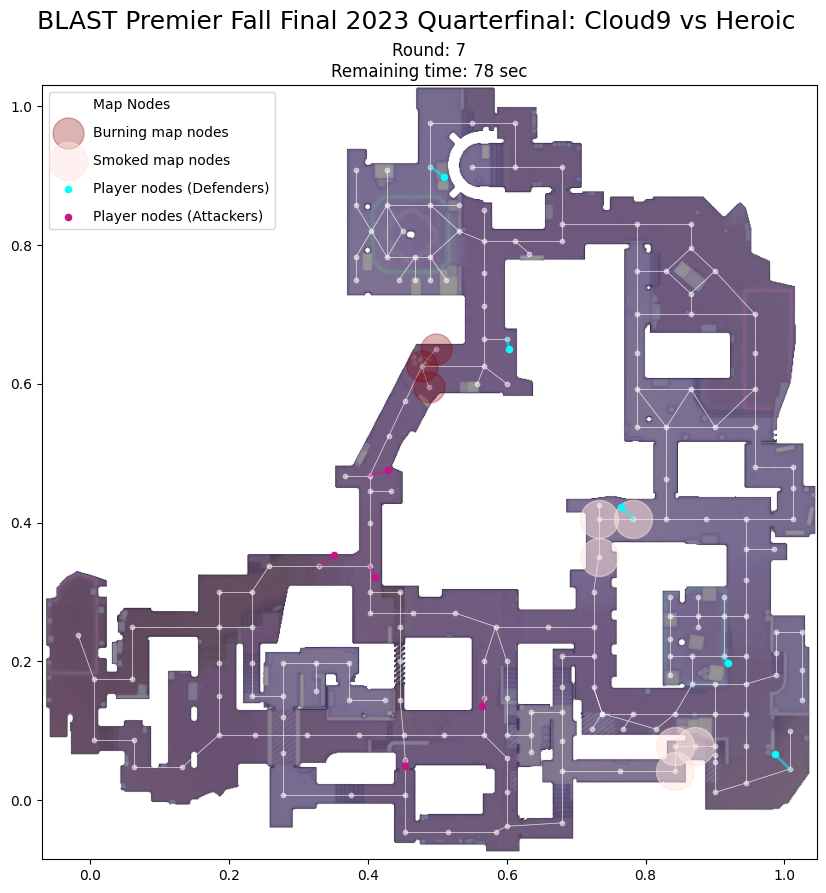

In [3]:
# Visualize graph
HeteroGraphVisualizer().visualize_snapshot(graphs[2550], 'de_inferno', 'l', plt_title='BLAST Premier Fall Final 2023 Quarterfinal: Cloud9 vs Heroic')

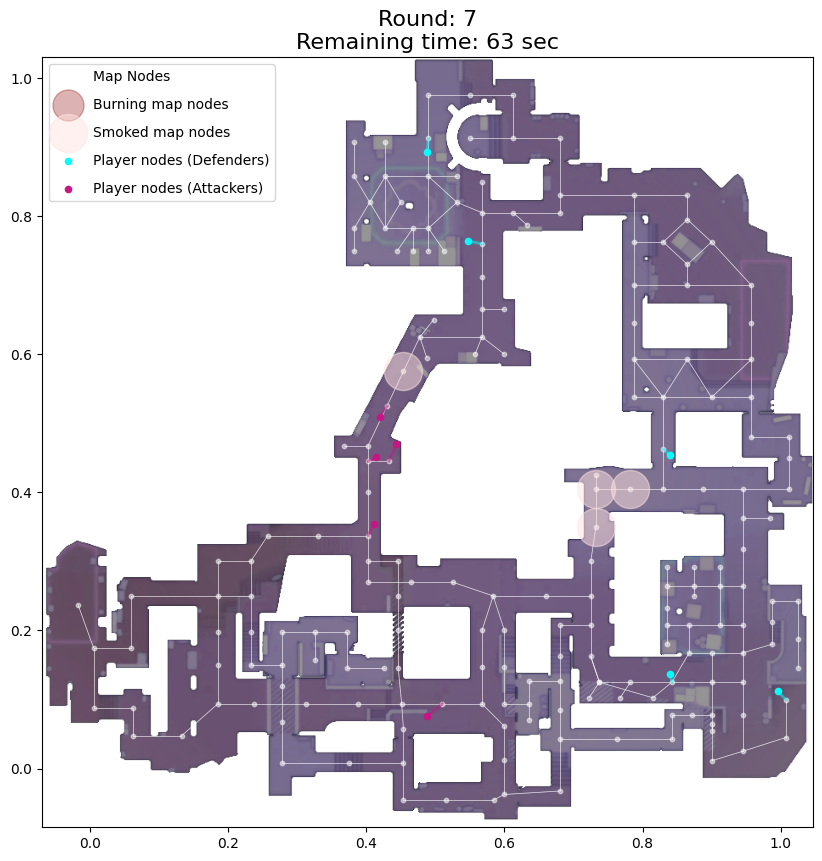

In [11]:
# Visualize graph
HeteroGraphVisualizer().visualize_snapshot(graphs[2619], 'de_inferno', 'l', plt_legend=True)